# Strategies to prevent overfitting in Neural Networks

## Introduction (5 min)

**Business Context.** You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.

**Business Problem.** Your task is to **build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)**.

**Analytical Context.** We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the *exact* star rating. The lowest score is 1 and the highest is 5.

Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.

## Setting up and preparing the data

We'll mainly be using the `keras` module from TensorFlow, but we'll also use `pandas` to read the CSV file and `sklearn` for some helper functions. We'll be using only the "Text" and "Score" columns in the `Reviews.csv` file.

### Exercise 1: (20 min)

Read in the `Reviews.csv` file and combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.

*Hint: `keras` will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.*

**Answer.**

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize,sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/ggoni/anaconda3/envs/extended_case_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ggoni/anaconda3/envs/extended_case_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ggoni/anaconda3/envs/extended_case_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
df=pd.read_csv('reviews.csv')

In [4]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [6]:
df.shape

(568454, 10)

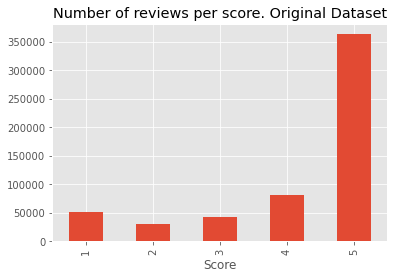

In [7]:
df.groupby(['Score'])['Id'].count().plot(kind='bar')
plt.title("Number of reviews per score. Original Dataset");

In [8]:
print(df['Score'].value_counts(normalize=True).sort_index())

1    0.091948
2    0.052368
3    0.075010
4    0.141885
5    0.638789
Name: Score, dtype: float64


_First, I will create a ```df_filtered```with the first 1,000 reviews for each score:_

In [9]:
df_filtered=pd.DataFrame()
for score in list(df.Score.unique()):
    df_score=df.loc[df['Score']==score,['Score','Text']]
    df_score=df_score.head(1000)
    df_filtered=pd.concat([df_filtered,df_score],axis=0)
#Scores must be mapped to a 0-4 scale
df_filtered['Score']=df_filtered['Score']-1


_Checking consistency:_

In [10]:
df_filtered.head()

,Score,Text
0,4,I have bought several of the Vitality canned d...
4,4,Great taffy at a great price. There was a wid...
6,4,This saltwater taffy had great flavors and was...
7,4,This taffy is so good. It is very soft and ch...
8,4,Right now I'm mostly just sprouting this so my...


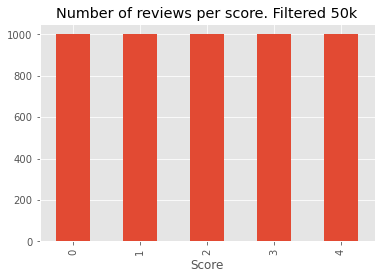

In [11]:
df_filtered.groupby(['Score'])['Text'].count().plot(kind='bar')
plt.title("Number of reviews per score. Filtered 50k");

_And it seems the requested filtering is ok._

## Tokenizing our texts

Keras comes with its own functions to preprocess text, including a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer). Unlike the `CountVectorizer` from `sklearn`, which produces sparse matrices, `keras` often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:

1. Create a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) (a mapping from each word in our corpus to a unique integer)
2. [Create sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)
3. [Pad or truncate](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) each sequence to a fixed length (very short texts get `0`s added to them, while very long ones are truncated).

The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.

### Exercise 2: (25 min)

Perform some exploratory analysis of the dataset to calculate the distribution of word lengths and number of unique words. Based on these, carry out the preprocessing steps described above, using appropriate values for the tokenizer cap and sequence length.

*Hint: $n$ should still be fairly large, since the point is only to ignore very rare words. A good benchmark for the word cap could be the number of words in the 80th percentile.*

**Answer.**

_First, I would like to clean the text, using the steps learned in Case 17.2_

_1. converting words to lower case_

_2. removing special characters_

_3. removing stopwords and extreme frequency words (Hint)_

_4. stemming_

In [12]:
import re

In [13]:
df_filtered['Text'].head()

0    I have bought several of the Vitality canned d...
4    Great taffy at a great price.  There was a wid...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
Name: Text, dtype: object

_Converting words to lowercase:_

In [14]:
df_filtered['Text']=df_filtered['Text'].apply(lambda x: x.lower())
df_filtered['Text'].head()

0    i have bought several of the vitality canned d...
4    great taffy at a great price.  there was a wid...
6    this saltwater taffy had great flavors and was...
7    this taffy is so good.  it is very soft and ch...
8    right now i'm mostly just sprouting this so my...
Name: Text, dtype: object

_Removing special characters:_

In [15]:
remove_special_chars=lambda x: re.sub('[^A-Za-z0-9 ]+', ' ',x)

In [16]:
df_filtered['Text']=df_filtered['Text'].apply(remove_special_chars)

In [17]:
df_filtered['Text'].head()

0    i have bought several of the vitality canned d...
4    great taffy at a great price   there was a wid...
6    this saltwater taffy had great flavors and was...
7    this taffy is so good   it is very soft and ch...
8    right now i m mostly just sprouting this so my...
Name: Text, dtype: object

_By now, the words to exclude will be just regular ```stopwords```.I will create a variable: more words could be necessary._

In [18]:
excluded_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
excluded_words.extend(eng_stop_words)

In [19]:
df_filtered['Text'].head()

0    i have bought several of the vitality canned d...
4    great taffy at a great price   there was a wid...
6    this saltwater taffy had great flavors and was...
7    this taffy is so good   it is very soft and ch...
8    right now i m mostly just sprouting this so my...
Name: Text, dtype: object

In [20]:
remove_stop_words=lambda x: ' '.join([word for word in x.split() if word not in (excluded_words)])
df_filtered['Text'] = df_filtered['Text'].apply(remove_stop_words)

In [21]:
df_filtered['Text'].head()

0    bought several vitality canned dog food produc...
4    great taffy great price wide assortment yummy ...
6    saltwater taffy great flavors soft chewy candy...
7    taffy good soft chewy flavors amazing would de...
8    right mostly sprouting cats eat grass love rot...
Name: Text, dtype: object

_I will also try to use a stemmer._

In [22]:
Stemmer=PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [23]:
def stem_text(text):
    return ' '.join([Stemmer.stem(w) for w in w_tokenizer.tokenize(text)])

In [24]:
df_filtered['Text'].apply(stem_text)

0        bought sever vital can dog food product found ...
4        great taffi great price wide assort yummi taff...
6        saltwat taffi great flavor soft chewi candi in...
7        taffi good soft chewi flavor amaz would defini...
8        right mostli sprout cat eat grass love rotat a...
                               ...                        
11964    bought walnut hope fresh natur tast better pac...
11977    buy cracker need someth gluten free snack glut...
11981    product known valu us fresh physic condit prod...
11998    purchaes twice far box gum realli hard product...
12038    tri garlic one made mistak wear ga mask use lo...
Name: Text, Length: 5000, dtype: object

_And now we are ready to train a Vectorizer with clean texts._

In [25]:
X_train,X_test,y_train,y_test=train_test_split(df_filtered['Text'],df_filtered['Score'],
                                               test_size=0.2,random_state=42)

In [26]:
tokenizer=Tokenizer()

In [27]:
tokenizer.fit_on_texts(X_train)

In [28]:
frequencies=pd.DataFrame(zip(tokenizer.index_word.values(),tokenizer.word_counts.values()),
                         columns=['word','frequency'])
frequencies.dtypes

word         object
frequency     int64
dtype: object

In [29]:
frequencies.sort_values(by='frequency',ascending=False,inplace=True)
frequencies.head()

,word,frequency
89,nice,4999
44,chocolate,2051
172,definitely,1488
54,found,1431
100,tasted,1401


In [30]:
print("The word frequency which represents the 80th percentile is {}".format(frequencies.frequency.quantile(0.8)))

The word frequency which represents the 80th percentile is 9.0


In [31]:
my_num_words=len(frequencies[frequencies.frequency>=9])+1

In [32]:
my_num_words

2577

_Now I will create tokenizers, to check if I am using ```num_words```correctly._

In [33]:
tokenizer_initial=Tokenizer()

In [34]:
tokenizer_initial.fit_on_texts(X_train)

In [35]:
X_train_tokens_initial=tokenizer_initial.texts_to_sequences(X_train)

In [36]:
import numpy as np

In [37]:
my_max_len=np.max([len(x) for x in X_train_tokens_initial])

In [38]:
tokenizer=Tokenizer(num_words=my_num_words)

In [39]:
tokenizer.fit_on_texts(X_train)

In [40]:
X_train_tokens=tokenizer.texts_to_sequences(X_train)

In [41]:
train_sequences=pad_sequences(X_train_tokens,maxlen=my_max_len)

In [42]:
test_sequences=pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=my_max_len)

In [43]:
train_sequences.shape

(4000, 1018)

In [44]:
test_sequences.shape

(1000, 1018)

In [45]:
train_labels=y_train
test_labels=y_test

In [46]:
train_sequences

array([[   0,    0,    0, ...,    9, 1818,   72],
       [   0,    0,    0, ...,    4,  286, 1104],
       [   0,    0,    0, ..., 1046,  156,   77],
       ...,
       [   0,    0,    0, ...,  311,   24,  151],
       [   0,    0,    0, ...,  688,  113,   77],
       [   0,    0,    0, ..., 2344,    3,   10]], dtype=int32)

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Flatten,Embedding,GlobalMaxPooling1D

## Building a basic neural network model 

Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.

Before we train a `keras` model, there is an additional `compile` step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the `fit` function. All of this is shown below.

Note the `validation_split=0.2` argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:

In [48]:
train_sequences.shape[1]

1018

_I will leave this section as the original requirement:_

```
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_sequences, labels, validation_split=0.2, epochs=10)

```

_My (hyper)parameters are different, since I did some adjustment and cleanindg._

### Exercise 3: (10 min)

How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?

**Answer.**

_I will change the structure a littel bit to haver ```history```. Also, I changed the last step activation function to ```softmax.```_

In [49]:
model = Sequential()
model.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dense_1 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 494,469
Trainable params: 494,469
Non-trainable params: 0
_________________________________________________________________


/Users/ggoni/anaconda3/envs/extended_case_7/lib/python3.7/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [50]:

history = model.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.5716 - accuracy: 0.3103 - val_loss: 1.5000 - val_accuracy: 0.3550
Epoch 2/10
3200/3200 [==============================] - 14s 4ms/step - loss: 1.3243 - accuracy: 0.4700 - val_loss: 1.3280 - val_accuracy: 0.4187
Epoch 3/10
3200/3200 [==============================] - 14s 4ms/step - loss: 1.0545 - accuracy: 0.5875 - val_loss: 1.3306 - val_accuracy: 0.4387
Epoch 4/10
3200/3200 [==============================] - 14s 4ms/step - loss: 0.8154 - accuracy: 0.7131 - val_loss: 1.4235 - val_accuracy: 0.4187
Epoch 5/10
3200/3200 [==============================] - 17s 5ms/step - loss: 0.6112 - accuracy: 0.7994 - val_loss: 1.5131 - val_accuracy: 0.4175
Epoch 6/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.4305 - accuracy: 0.8737

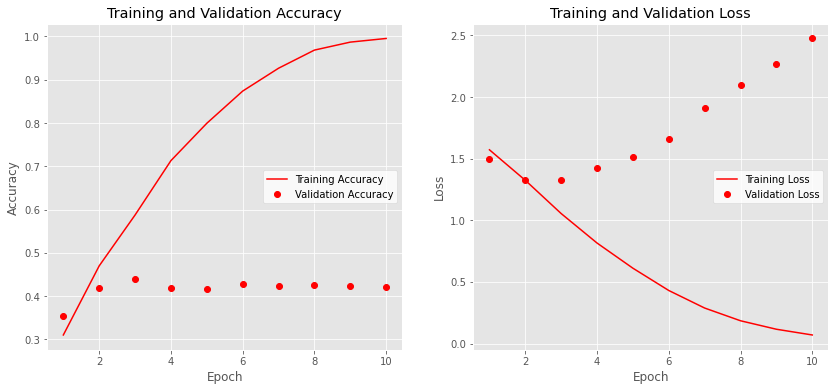

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training Accuracy',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation Accuracy',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training Loss',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation Loss',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_It seems that this model tends to overfit on the training sequences, as it is not fitting very well to predict on the validation sets in each epoch._

_Note that the prediction for each class in the test -just for a reference - would set gives us:_

In [52]:
pd.Series(model.predict_classes(train_sequences)).value_counts(normalize=True)

0    0.21225
4    0.19975
3    0.19775
1    0.19625
2    0.19400
dtype: float64

In [53]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [54]:
pred_test_labels=model.predict_classes(test_sequences)
confusion_matrix(test_labels,pred_test_labels)

array([[111,  36,  20,  14,   9],
       [ 44,  86,  36,  23,  21],
       [ 25,  43,  66,  32,  26],
       [ 11,  23,  42,  75,  41],
       [  7,   9,  21,  57, 122]])

In [55]:
print("The accuracy score is {:.4f}".format(accuracy_score(test_labels,pred_test_labels)))

The accuracy score is 0.4600


_Just to compare, supose we randomly assign a label between 0 and 4 (1 and 5 originally). If we would assign a random label, we would obtain an accuracy of ~20%:_

In [56]:
np.random.seed(42)
acc_random=[]
for i in range(10000):
    random_labels=np.random.randint(0,5,1000).reshape(-1,1)
    acc_random.append(accuracy_score(test_labels, random_labels))



In [57]:
print("The mean accuracy for a'random labeler' would be: {:.4f}".format(round(np.mean(acc_random),2)))

The mean accuracy for a'random labeler' would be: 0.2000


_Our model more than doubles a random guess, but could still leave room for improvement._


## Experimenting with different regularization strategies

There are many different ways to mitigate overfitting in a neural network, collectively known as *regularization* techniques. One common regularization technique is called [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). 

### Exercise 4: (25 min)

Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

_I am going to use 40% and 20% Dropout rates in the hidden layers for a start:_

In [58]:
from keras.layers import Dropout

In [59]:
model_dropout = Sequential()
model_dropout.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(128, activation='relu'))
model_dropout.add(Dropout(0.4))
model_dropout.add(Dense(128, activation='relu'))
model_dropout.add(GlobalMaxPooling1D())
model_dropout.add(Dense(5, activation='softmax'))
model_dropout.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dropout.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1018, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1018, 128)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [60]:
history_dropout = model_dropout.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.6011 - accuracy: 0.2434 - val_loss: 1.5847 - val_accuracy: 0.2475
Epoch 2/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.5289 - accuracy: 0.3266 - val_loss: 1.4849 - val_accuracy: 0.3600
Epoch 3/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.3549 - accuracy: 0.4197 - val_loss: 1.3755 - val_accuracy: 0.3950
Epoch 4/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.1944 - accuracy: 0.4994 - val_loss: 1.3446 - val_accuracy: 0.4238
Epoch 5/10
3200/3200 [==============================] - 17s 5ms/step - loss: 1.0513 - accuracy: 0.5622 - val_loss: 1.3521 - val_accuracy: 0.4300
Epoch 6/10
3200/3200 [==============================] - 17s 5ms/step - loss: 0.9426 - accuracy: 0.6359 - val_loss: 1.4325 - val_accuracy: 0.4187
Epoch 7/10
3200/3200 [==============================] - 17s 5ms/step - loss: 0.8464

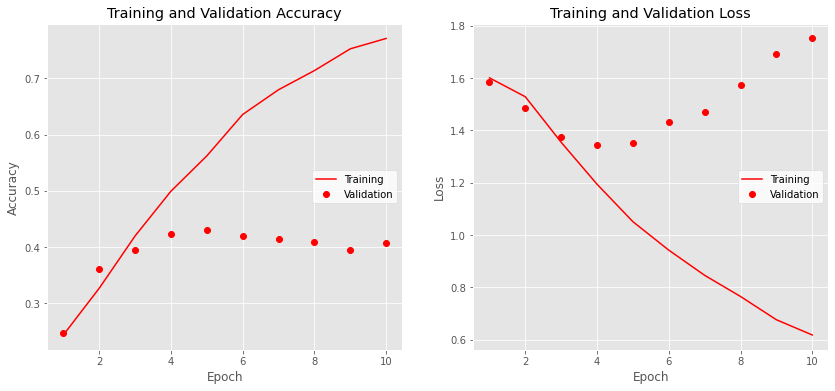

In [61]:
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy'] 
loss = history_dropout.history['loss'] 
val_loss = history_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

In [62]:
pred_test_wd_labels=model_dropout.predict_classes(test_sequences)

_It seems that the model is not overfitting as much as the first version, but neither is improving its capability to predict on a validation set. Also, it seems that after epoch 4 it does not have any sense to keep fitting._



### Exercise 5: (45 min)

Keras allows you to add [L1](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1), [L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2), or [L1 and L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2) combined regularizers on individual layers by passing in the `kernel_regularizer`, `bias_regularizer` or `activity_regularizer` arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.

Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

In [63]:
from keras.regularizers import l1,l2,l1_l2

In [64]:
model_reg1= Sequential()
model_reg1.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model_reg1.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model_reg1.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model_reg1.add(GlobalMaxPooling1D())
model_reg1.add(Dense(5, activation='softmax',kernel_regularizer=l2(0.001)))
model_reg1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_reg1.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dense_7 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 494,469
Trainable params: 494,469
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_reg1 = model_reg1.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.7699 - accuracy: 0.2775 - val_loss: 1.6745 - val_accuracy: 0.3000
Epoch 2/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.5422 - accuracy: 0.4041 - val_loss: 1.5093 - val_accuracy: 0.3750
Epoch 3/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.3320 - accuracy: 0.4847 - val_loss: 1.4899 - val_accuracy: 0.3988
Epoch 4/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.1674 - accuracy: 0.5600 - val_loss: 1.5328 - val_accuracy: 0.4013
Epoch 5/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.0376 - accuracy: 0.6394 - val_loss: 1.6174 - val_accuracy: 0.4137
Epoch 6/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.9158 - accuracy: 0.6947 - val_loss: 1.7461 - val_accuracy: 0.3925
Epoch 7/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.8005

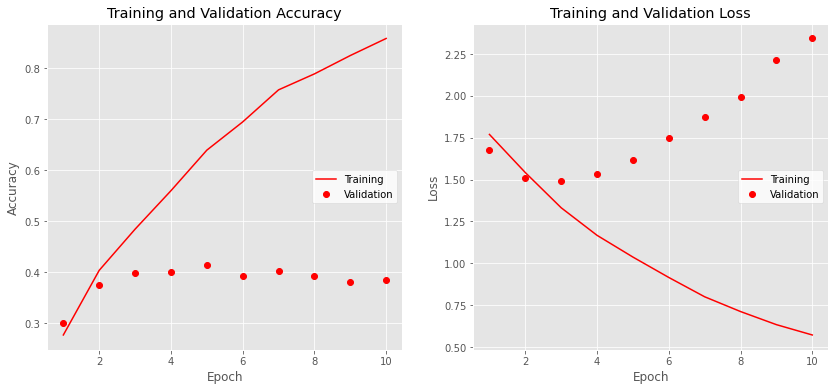

In [66]:
acc = history_reg1.history['accuracy']
val_acc = history_reg1.history['val_accuracy'] 
loss = history_reg1.history['loss'] 
val_loss = history_reg1.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_Trying a new second model:_

In [67]:
model_reg2= Sequential()
model_reg2.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model_reg2.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_reg2.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_reg2.add(GlobalMaxPooling1D())
model_reg2.add(Dense(5, activation='softmax',kernel_regularizer=l2(0.01)))
model_reg2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_reg2.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dense_10 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 645       
Total params: 494,469
Trainable params: 494,469
Non-trainable params: 0
_________________________________________________________________


In [68]:
history_reg2 = model_reg1.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.5358 - accuracy: 0.8687 - val_loss: 2.5036 - val_accuracy: 0.3713
Epoch 2/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.4827 - accuracy: 0.8922 - val_loss: 2.5809 - val_accuracy: 0.3725
Epoch 3/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.4426 - accuracy: 0.9141 - val_loss: 2.6943 - val_accuracy: 0.3787
Epoch 4/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.4124 - accuracy: 0.9250 - val_loss: 2.8440 - val_accuracy: 0.3625
Epoch 5/10
3200/3200 [==============================] - 17s 5ms/step - loss: 0.3898 - accuracy: 0.9328 - val_loss: 2.9683 - val_accuracy: 0.3738
Epoch 6/10
3200/3200 [==============================] - 27s 8ms/step - loss: 0.3612 - accuracy: 0.9450 - val_loss: 3.0735 - val_accuracy: 0.3750
Epoch 7/10
3200/3200 [==============================] - 16s 5ms/step - loss: 0.3479

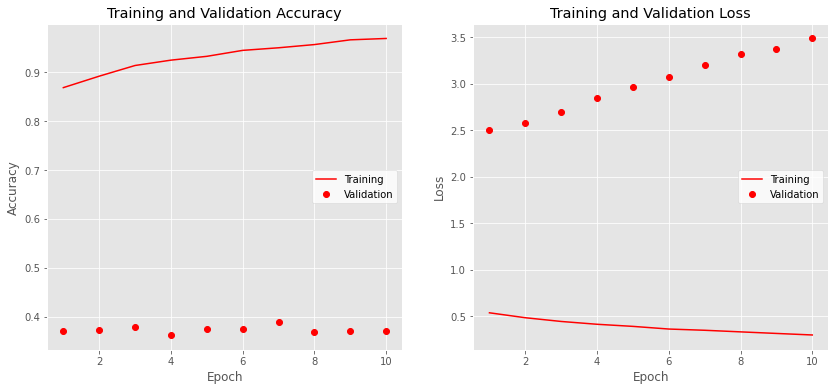

In [69]:
acc = history_reg2.history['accuracy']
val_acc = history_reg2.history['val_accuracy'] 
loss = history_reg2.history['loss'] 
val_loss = history_reg2.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_Changing regularizers for a third model:_

In [70]:
model_reg3= Sequential()
model_reg3.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model_reg3.add(Dense(128, activation='relu',kernel_regularizer=l1(0.01)))
model_reg3.add(Dense(128, activation='relu',kernel_regularizer=l1(0.01)))
model_reg3.add(GlobalMaxPooling1D())
model_reg3.add(Dense(5, activation='softmax',kernel_regularizer=l1(0.01)))
model_reg3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_reg3.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dense_13 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 494,469
Trainable params: 494,469
Non-trainable params: 0
_________________________________________________________________


In [71]:
history_reg3 = model_reg3.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 14s 4ms/step - loss: 14.4940 - accuracy: 0.2181 - val_loss: 4.9682 - val_accuracy: 0.2025
Epoch 2/10
3200/3200 [==============================] - 13s 4ms/step - loss: 2.3425 - accuracy: 0.1925 - val_loss: 1.6581 - val_accuracy: 0.1988
Epoch 3/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.6520 - accuracy: 0.2034 - val_loss: 1.6510 - val_accuracy: 0.1988
Epoch 4/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.6512 - accuracy: 0.2034 - val_loss: 1.6508 - val_accuracy: 0.1988
Epoch 5/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.6511 - accuracy: 0.1963 - val_loss: 1.6511 - val_accuracy: 0.1988
Epoch 6/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.6512 - accuracy: 0.2034 - val_loss: 1.6510 - val_accuracy: 0.1988
Epoch 7/10
3200/3200 [==============================] - 13s 4ms/step - loss: 1.651

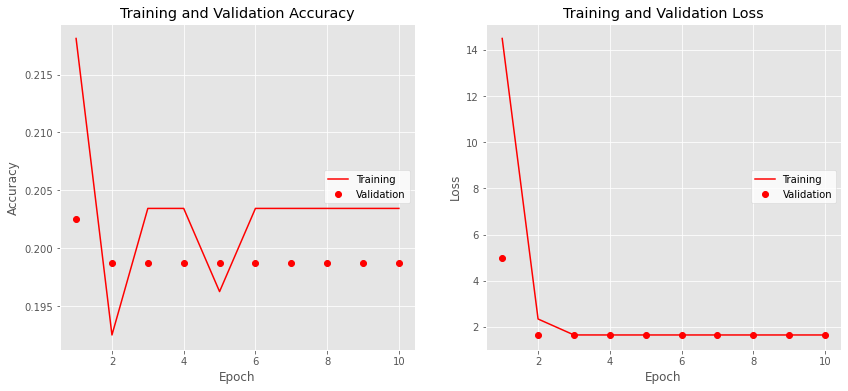

In [72]:
acc = history_reg3.history['accuracy']
val_acc = history_reg3.history['val_accuracy'] 
loss = history_reg3.history['loss'] 
val_loss = history_reg3.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_And It seems that l1 regularization parameter is too high. Going for a fourth model:_

In [73]:
model_reg4= Sequential()
model_reg4.add(Embedding(3600, 128, input_length=train_sequences.shape[1]))
model_reg4.add(Dense(128, activation='relu',activity_regularizer=l2(0.05),
                     kernel_regularizer=l1_l2(0.001,0.01)))
model_reg4.add(Dense(128, activation='relu',activity_regularizer=l2(0.05),
                     kernel_regularizer=l1_l2(0.001,0.01)))
model_reg4.add(GlobalMaxPooling1D())
model_reg4.add(Dense(5, activation='softmax',kernel_regularizer=l1_l2(0.001,0.01)))
model_reg4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_reg4.model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1018, 128)         460800    
_________________________________________________________________
dense_16 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
dense_17 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645       
Total params: 494,469
Trainable params: 494,469
Non-trainable params: 0
_________________________________________________________________


In [74]:
history_reg4 = model_reg4.fit(train_sequences,train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 15s 5ms/step - loss: 9.0841 - accuracy: 0.1925 - val_loss: 4.4125 - val_accuracy: 0.1988
Epoch 2/10
3200/3200 [==============================] - 14s 4ms/step - loss: 3.9298 - accuracy: 0.1947 - val_loss: 3.6103 - val_accuracy: 0.1988
Epoch 3/10
3200/3200 [==============================] - 14s 5ms/step - loss: 3.4775 - accuracy: 0.1956 - val_loss: 3.3787 - val_accuracy: 0.1988
Epoch 4/10
3200/3200 [==============================] - 14s 4ms/step - loss: 3.3074 - accuracy: 0.1975 - val_loss: 3.2388 - val_accuracy: 0.1988
Epoch 5/10
3200/3200 [==============================] - 14s 4ms/step - loss: 3.1756 - accuracy: 0.1984 - val_loss: 3.1133 - val_accuracy: 0.1988
Epoch 6/10
3200/3200 [==============================] - 14s 4ms/step - loss: 3.0553 - accuracy: 0.2009 - val_loss: 2.9984 - val_accuracy: 0.1988
Epoch 7/10
3200/3200 [==============================] - 14s 4ms/step - loss: 2.9453

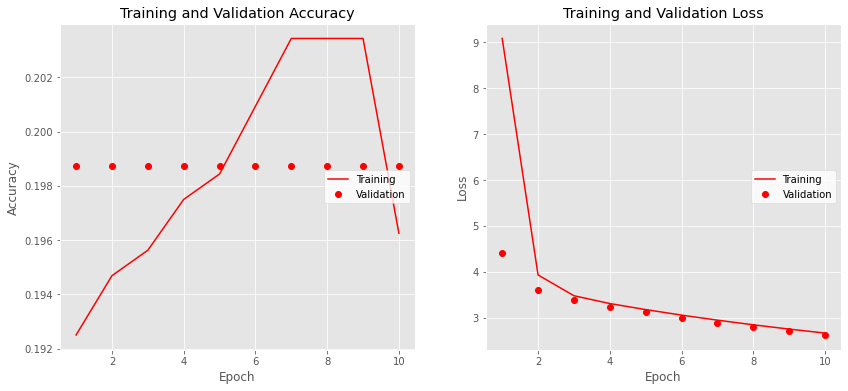

In [75]:
acc = history_reg4.history['accuracy']
val_acc = history_reg4.history['val_accuracy'] 
loss = history_reg4.history['loss'] 
val_loss = history_reg4.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_None of the combinations I tried seems to work very well._



## Regularization through adding more data

Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.

### Exercise 6: (40 min)

How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.

**Answer.**

_What would happen if I use 5,000 instead of 1,000 cases por each class? I will find out._

In [76]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [77]:
df_filtered2=pd.DataFrame()
for score in list(df.Score.unique()):
    df_score=df.loc[df['Score']==score,['Score','Text']]
    df_score=df_score.head(5000)
    df_filtered2=pd.concat([df_filtered2,df_score],axis=0)
#Scores must be mapped to a 0-4 scale
df_filtered2['Score']=df_filtered2['Score']-1

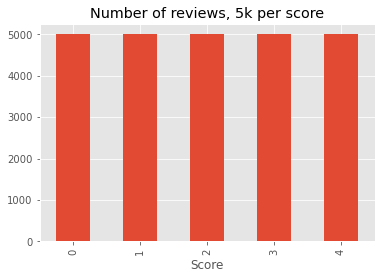

In [78]:
df_filtered2.groupby(['Score'])['Text'].count().plot(kind='bar')
plt.title("Number of reviews, 5k per score");

In [79]:
df_filtered2['Text'].tail()

63528    This product was tried by my entire family, ev...
63542    Nice flavor- I would have preferred it slightl...
63544    I found the illy issimo Caffe Espresso flavore...
63545    If I made my usual morning coffee in my coffee...
63546    It's strong coffee but not aggressively so.  S...
Name: Text, dtype: object

_Converting words to lowercase:_

In [80]:
df_filtered2['Text']=df_filtered2['Text'].apply(lambda x: x.lower())
df_filtered2['Text'].tail()

63528    this product was tried by my entire family, ev...
63542    nice flavor- i would have preferred it slightl...
63544    i found the illy issimo caffe espresso flavore...
63545    if i made my usual morning coffee in my coffee...
63546    it's strong coffee but not aggressively so.  s...
Name: Text, dtype: object

_Removing special characters:_

In [81]:
df_filtered2['Text']=df_filtered2['Text'].apply(remove_special_chars)

In [82]:
df_filtered2['Text'].tail()

63528    this product was tried by my entire family  ev...
63542    nice flavor  i would have preferred it slightl...
63544    i found the illy issimo caffe espresso flavore...
63545    if i made my usual morning coffee in my coffee...
63546    it s strong coffee but not aggressively so   s...
Name: Text, dtype: object

In [83]:
df_filtered2['Text'] = df_filtered2['Text'].apply(remove_stop_words)

In [84]:
df_filtered2['Text'].tail()

63528    product tried entire family everyone disliked ...
63542    nice flavor would preferred slightly sweeter r...
63544    found illy issimo caffe espresso flavored coff...
63545    made usual morning coffee coffee maker like li...
63546    strong coffee aggressively slightly sweet top ...
Name: Text, dtype: object

_Using stemmer._

In [85]:
df_filtered2['Text'].apply(stem_text)

0        bought sever vital can dog food product found ...
4        great taffi great price wide assort yummi taff...
6        saltwat taffi great flavor soft chewi candi in...
7        taffi good soft chewi flavor amaz would defini...
8        right mostli sprout cat eat grass love rotat a...
                               ...                        
63528    product tri entir famili everyon dislik espres...
63542    nice flavor would prefer slightli sweeter revi...
63544    found illi issimo caff espresso flavor coffe d...
63545    made usual morn coffe coffe maker like littl s...
63546    strong coffe aggress slightli sweet top label ...
Name: Text, Length: 25000, dtype: object

_And now we are ready to train a Vectorizer with clean texts._

In [86]:
df_filtered2['Text'].tail()

63528    product tried entire family everyone disliked ...
63542    nice flavor would preferred slightly sweeter r...
63544    found illy issimo caffe espresso flavored coff...
63545    made usual morning coffee coffee maker like li...
63546    strong coffee aggressively slightly sweet top ...
Name: Text, dtype: object

In [87]:
X_train2,X_test2,y_train2,y_test2=train_test_split(df_filtered2['Text'],df_filtered2['Score'],
                                               test_size=0.2,random_state=42)

In [88]:
X_train2.shape

(20000,)

In [89]:
tokenizer2=Tokenizer()

In [90]:
tokenizer2.fit_on_texts(X_train2)

In [91]:
frequencies2=pd.DataFrame(zip(tokenizer2.index_word.values(),tokenizer2.word_counts.values()),
                         columns=['word','frequency'])
frequencies2.dtypes

word         object
frequency     int64
dtype: object

In [92]:
frequencies2.sort_values(by='frequency',ascending=False,inplace=True)
frequencies2.head()

,word,frequency
63,give,26468
277,fact,11043
72,flavors,7692
3,good,7469
5,one,6939


In [93]:
print("The word frequency which represents the 80th percentile is {}".format(frequencies2.frequency.quantile(0.8)))

The word frequency which represents the 80th percentile is 12.0


In [94]:
my_num_words2=len(frequencies2[frequencies2.frequency>=14])+1

In [95]:
my_num_words2

5203

In [96]:
#import numpy as np

In [97]:
tokenizer=Tokenizer()

In [98]:
tokenizer.fit_on_texts(X_train2)

In [99]:
X_train_tokens2=tokenizer.texts_to_sequences(X_train2)

In [100]:
my_max_len2=np.max([len(x) for x in X_train_tokens2])
print(my_max_len2)

1018


In [101]:
tokenizer=Tokenizer(num_words=my_num_words2)

In [102]:
tokenizer.fit_on_texts(X_train2)

In [103]:
X_train_tokens2=tokenizer.texts_to_sequences(X_train2)

In [104]:
train_sequences2=pad_sequences(X_train_tokens2,maxlen=my_max_len2)

In [105]:
test_sequences2=pad_sequences(tokenizer.texts_to_sequences(X_test2),maxlen=my_max_len2)

In [106]:
train_sequences2.shape

(20000, 1018)

In [107]:
test_sequences2.shape

(5000, 1018)

In [108]:
train_labels2=y_train2
test_labels2=y_test2

In [109]:
train_sequences2

array([[   0,    0,    0, ...,   52,  158,  349],
       [   0,    0,    0, ..., 1319,  666,   42],
       [   0,    0,    0, ..., 1637,  369,   90],
       ...,
       [   0,    0,    0, ..., 1038,    3,   11],
       [   0,    0,    0, ...,    1,    1,  744],
       [   0,    0,    0, ..., 1095, 2170, 2960]], dtype=int32)

In [110]:
model_newData = Sequential()
model_newData.add(Embedding(my_num_words2, 128, input_length=train_sequences2.shape[1]))
model_newData.add(Dense(128, activation='relu'))
model_newData.add(Dense(128, activation='relu'))
model_newData.add(GlobalMaxPooling1D())
model_newData.add(Dense(5, activation='softmax'))
model_newData.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_newData.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1018, 128)         665984    
_________________________________________________________________
dense_19 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 645       
Total params: 699,653
Trainable params: 699,653
Non-trainable params: 0
_________________________________________________________________


/Users/ggoni/anaconda3/envs/extended_case_7/lib/python3.7/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [111]:
train_sequences2.shape

(20000, 1018)

In [112]:
train_labels2

41917    2
45537    2
1576     4
18359    3
2388     4
        ..
19042    2
4109     0
1331     4
13849    1
45692    2
Name: Score, Length: 20000, dtype: int64

In [113]:
history_newData = model_newData.fit(train_sequences2,train_labels2,
                    epochs=10,
                    batch_size=1000,
                    validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 72s 4ms/step - loss: 1.5947 - accuracy: 0.3035 - val_loss: 1.5755 - val_accuracy: 0.4030
Epoch 2/10
16000/16000 [==============================] - 69s 4ms/step - loss: 1.5375 - accuracy: 0.4642 - val_loss: 1.5098 - val_accuracy: 0.4155
Epoch 3/10
16000/16000 [==============================] - 69s 4ms/step - loss: 1.4336 - accuracy: 0.4654 - val_loss: 1.3993 - val_accuracy: 0.4218
Epoch 4/10
16000/16000 [==============================] - 71s 4ms/step - loss: 1.2887 - accuracy: 0.4941 - val_loss: 1.2805 - val_accuracy: 0.4572
Epoch 5/10
16000/16000 [==============================] - 71s 4ms/step - loss: 1.1587 - accuracy: 0.5372 - val_loss: 1.2188 - val_accuracy: 0.4770
Epoch 6/10
16000/16000 [==============================] - 82s 5ms/step - loss: 1.0553 - accuracy: 0.5805 - val_loss: 1.1946 - val_accuracy: 0.4845
Epoch 7/10
16000/16000 [==============================] - 79s 5ms/ste

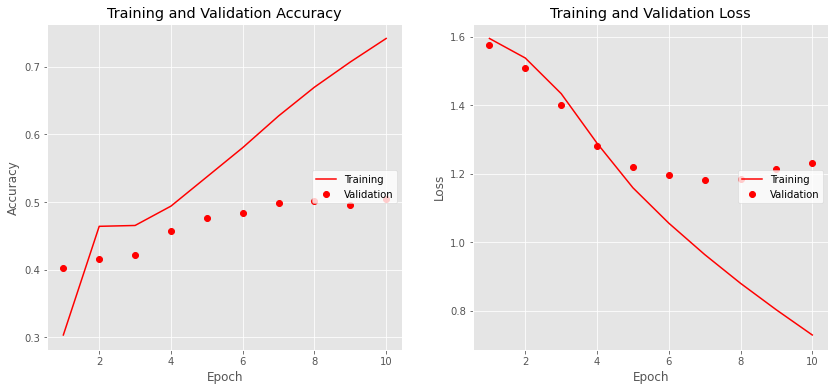

In [114]:
acc = history_newData.history['accuracy']
val_acc = history_newData.history['val_accuracy'] 
loss = history_newData.history['loss'] 
val_loss = history_newData.history['val_loss']
epochs = range(1, len(acc) + 1)



fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(14,6))
ax0.plot(epochs,acc,'b',label='Training',color='red')
ax0.plot(epochs,val_acc,'bo',label='Validation',color='red')
ax0.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax0.legend(loc='right',facecolor='white')

ax1.plot(epochs,loss,'b',label='Training ',color='red')
ax1.plot(epochs,val_loss,'bo',label='Validation',color='red')
ax1.set(title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
ax1.legend(loc='right',facecolor='white');

_We have made a great effort to compute the best fit for 5X the original numbers of records. Note that the overfitting is not that evident. However, It seems that our number of epochs is excesive when trespassing a threshold. With more time and resources, I would keep on adding records and check if validation accuracy is improving at the margin._

## Regularization through early stopping

We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.

You can do this manually by inspecting the data as we have done above and modifying the `epochs` argument in `fit()`, but Keras also allows you to easily do this automatically via an [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

### Exercise 7: (25 min)

Experiment with the `EarlyStopping` callback and explain the results.

**Answer.**

In [115]:
from keras.callbacks import EarlyStopping

_We will enable:Early stop on validation accuracy, based on ```validation_loss``` and a 0.02 difference in the indicator to stop, if needed._

In [116]:
from keras import callbacks
callback = callbacks.EarlyStopping(monitor='val_loss',mode='min',min_delta=0.02)

In [117]:
model_newData2 = Sequential()
model_newData2.add(Embedding(my_num_words2, 128, input_length=train_sequences2.shape[1]))
model_newData2.add(Dense(128, activation='relu'))
model_newData2.add(Dense(128, activation='relu'))
model_newData2.add(GlobalMaxPooling1D())
model_newData2.add(Dense(5, activation='softmax'))
model_newData2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_newData2.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1018, 128)         665984    
_________________________________________________________________
dense_22 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1018, 128)         16512     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 645       
Total params: 699,653
Trainable params: 699,653
Non-trainable params: 0
_________________________________________________________________


In [118]:
history_newData = model_newData2.fit(train_sequences2,train_labels2,
                    epochs=10,
                    batch_size=100,
                    validation_split=0.2,
                    callbacks=[callback])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 63s 4ms/step - loss: 1.4609 - accuracy: 0.3724 - val_loss: 1.2737 - val_accuracy: 0.4527
Epoch 2/10
16000/16000 [==============================] - 63s 4ms/step - loss: 1.1677 - accuracy: 0.5098 - val_loss: 1.2001 - val_accuracy: 0.4915
Epoch 3/10
16000/16000 [==============================] - 66s 4ms/step - loss: 1.0015 - accuracy: 0.5966 - val_loss: 1.2084 - val_accuracy: 0.4938


## Evaluating our model

Unlike in most previous cases, we used *three* splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.

For experiments, it's very important that your model is only run **once** on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided *before the experiment started*).

### Exercise 8: (30 min)

Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose *what kinds of mistakes it makes*. Explain whether these mistakes are expected or not. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?

*Hint: You can use the [`predict_classes`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes) method on your model to get the most probable class directly.*

**Answer.**

In [119]:
test_labels2.index.max()

89293

In [120]:
pred_def_test_labels2=pd.Series(history_newData.model.predict_classes(test_sequences2),index=test_labels2.index)

In [121]:
accuracy_score(test_labels2,pred_def_test_labels2)

0.5072

In [122]:
df_diff=pd.concat([test_labels2,pred_def_test_labels2],axis=1)
df_diff.columns=['real','predicted']

In [123]:
df_diff['diff']=df_diff['real']-df_diff['predicted']

In [124]:
indices=df_diff[df_diff['diff'].apply(abs)==4].sample(5,random_state=42).index

In [125]:
df_diff.loc[indices]

,real,predicted,diff
27325,0,4,-4
14834,0,4,-4
6218,0,4,-4
25030,0,4,-4
7375,4,0,4


In [126]:
indices

Int64Index([27325, 14834, 6218, 25030, 7375], dtype='int64')

In [127]:
for _,index in enumerate(indices):
    print("================================================================================================")
    print("Review #{}".format(index))
    print(df_filtered2.loc[index,'Text'])
    print("================================================================================================")

Review #27325
great gift son wife many sleepless nights new baby new years day dinner brewed one blends pie aroma taste excellent
Review #14834
disapointed salt since truffle salt expected taste least hint truffle didnt want really good truffle flavored salt order fusion black truffle salt wonderfully strong aroma great flavor
Review #6218
tastes like jack links brand wild bill even texture totally different wild bill recommended
Review #25030
drinking chocolate raspberry truffle coffee quite recommending friends loved first conscious thought every morning would great tasting cup coffee yum happened last boxes absolutely tastless wonderful aroma either might well drinking hot water disappointment wonderful flavor memory sadly giving chocolate raspberry truffle purchase another flavor
Review #7375
nothing better huge baked sweet potato real butter splenda brown sugar totally covering butter sweet potato makes want fix one right


_It seems that the use of some words with double meaning could make the clasiffier to get confused. Note that in review #27325, words like ```great``` and ```excellent```are written. In this case we predict a 5 (4+1), when the real review was 1. On the other hand, Review #7375 is very good (5), but the model predicted it as a 1. Note that some words are likely confusing words like ```nothing``` , ```fix``` and ```potato``` are used.
If more time and resources were given, I would try to :

_1. use n-grams_

_2. some kind of embedding to check again (Like Glove, for instance.)_